In [4]:
import sys
sys.path.insert(0, "../source/")
import pyomo
import numpy as np
import matplotlib.pyplot as plt

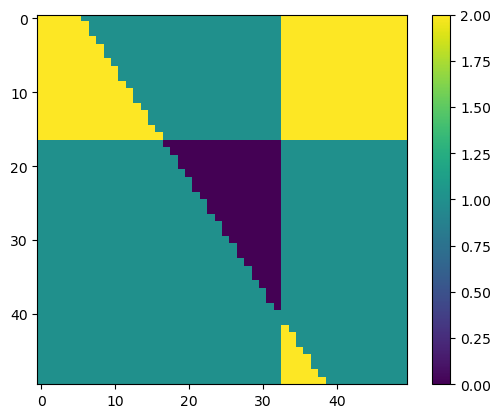

In [5]:
# polygon obstacle
class polygon_obstacle:
    def __init__(self, vertices):
        """
        :param vertices:  polygon vertices in clockwise order
        """
        self.vertices = np.array(vertices)

    def unit_vec(self, vector):
        return vector/np.linalg.norm(vector)

    @property
    def side_vectors(self):
        """Unit vectors along perimeter of polygon"""
        return np.array([
            self.unit_vec(self.vertices[i] - self.vertices[i - 1]) for i in range(len(self.vertices))
        ])

    @property
    def orthogonal_vectors(self):
        """Unit normal vectors for polygon sides"""
        return np.array([
            np.array([-v[1], v[0]]) for v in self.side_vectors
        ])

    @property
    def constants(self):
        """
        orthogonal . x >= constant
        """
        return np.array([
            np.dot(vertex, v) for vertex, v in zip(self.vertices, self.orthogonal_vectors)
        ])

polygon = polygon_obstacle([[0, 0], [1, 1.5], [1, 0]])

x = np.linspace(-1, 2)
y = np.linspace(-1, 2)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for v, c in zip(polygon.orthogonal_vectors, polygon.constants):
    Z += (v[0]*X + v[1]*Y >= c)
plt.figure()
plt.imshow(Z)
plt.colorbar()

# Pyomo DAE

In [51]:
import pyomo.environ as pyenv
import pyomo.gdp as pygdp
from scipy.integrate import RK45

model = pyenv.ConcreteModel()

x0 = 0.8
y0 = 0.7
theta0 = 0.0
x_final = 0.0
y_final = 0.0
theta_final = np.pi

M = 10

regularization = 0.1

# Obstacles
cxs = [0.5, 0.4, 0.0]
cys = [0.5, 0.0, 0.1]
rs = [0.25, 0.15, 0.099]
obstacle_shape = "diamond"

# bounds
x_lower = 0
x_upper = 1
y_lower = 0
y_upper = 1
v_lower = 0.1
v_upper = 1
omega_lower = -100*np.pi
omega_upper = 100*np.pi

model.T = 4  # final time
model.NK = 500  # number of time steps
model.h = model.T/model.NK  # time grid spacing
model.K = pyenv.RangeSet(model.NK)
model.K0 = pyenv.RangeSet(0, model.NK)
model.Km1 = pyenv.RangeSet(model.NK - 1)  # [1, NK - 1]
model.K0m1 = pyenv.RangeSet(0, model.NK - 1)  # [1, NK - 1]

# Initial path
initial_x = np.linspace(x0, 0.0, model.NK)
initial_y = np.linspace(y0, 0.0, model.NK)
initial_theta = np.linspace(0.2, 0.5, model.NK)
initial_theta = np.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_v = np.ones(initial_x.shape)

# Use previously solved path
initial_x = x
initial_y = y
initial_theta = theta
initial_v = v
initial_omega = omega

model.x = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(x_lower, x_upper), initialize=dict(zip(model.K0, initial_x))) # p(t)_x
model.y = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(y_lower, y_upper), initialize=dict(zip(model.K0, initial_y))) # p(t)_y
model.theta = pyenv.Var(model.K0, domain=pyenv.Reals)  # theta can be unbounded, arctan(dy/dx)
model.v = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(v_lower, v_upper), initialize=dict(zip(model.K0, initial_v))) # velocity; control parameter
model.omega = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(omega_lower, omega_upper)) # angular velocity; control parameter

def x_forward_Euler(model, k):
    return model.x[k + 1] - model.x[k] == model.h * model.v[k] * pyenv.cos(model.theta[k])
model.x_forward_Euler = pyenv.Constraint(model.K0m1, rule=x_forward_Euler)

def y_forward_Euler(model, k):
    return model.y[k + 1] - model.y[k] == model.h * model.v[k] * pyenv.sin(model.theta[k])
model.y_forward_Euler = pyenv.Constraint(model.K0m1, rule=y_forward_Euler)

def theta_forward_Euler(model, k):
    return model.theta[k + 1] - model.theta[k] == model.h * model.omega[k]
model.theta_forward_Euler = pyenv.Constraint(model.K0m1, rule=theta_forward_Euler)

def initial_x_rule(model):
    return model.x[0] == x0
model.initial_x_rule = pyenv.Constraint(rule=initial_x_rule)

def initial_y_rule(model):
    return model.y[0] == y0
model.initial_y_rule = pyenv.Constraint(rule=initial_y_rule)

def initial_theta_rule(model):
    return model.theta[0] == theta0
# model.initial_theta_rule = pyenv.Constraint(rule=initial_theta_rule)

def final_x_rule(model):
    return model.x[model.NK] == x_final
model.final_x_rule = pyenv.Constraint(rule=final_x_rule)

def final_y_rule(model):
    return model.y[model.NK] == y_final
model.final_y_rule = pyenv.Constraint(rule=final_y_rule)

# Allow for +- 2*pi
def final_theta_sin_rule(model):
    return pyenv.sin(model.theta[model.NK]) == pyenv.sin(theta_final)

def final_theta_cos_rule(model):
    return pyenv.cos(model.theta[model.NK]) == pyenv.cos(theta_final)
# model.final_theta_sin_rule = pyenv.Constraint(rule=final_theta_sin_rule)
# model.final_theta_cos_rule = pyenv.Constraint(rule=final_theta_cos_rule)

def diamond_obstacle_rule(model, k, cx, cy, r):
    """1-norm obstacle with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return abs(model.x[k] - cx)/rx +  abs(model.y[k] - cy)/ry >= 1

def square_obstacle_rule(model, k, cx, cy, r):
    """1-norm obstacle rotated with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return 0.5*abs((model.x[k]-cx)/rx + (model.y[k]-cy)/ry) +  0.5*abs((model.x[k]-cx)/rx - (model.y[k]-cy)/ry) >= 1

def circle_obstacle_rule(model, k, cx, cy, r):
    """Circle obstacle with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return (model.x[k] - cx)**2/(rx**2) + (model.y[k] - cy)**2/(ry**2) >= 1

if obstacle_shape == "circle":
    model.circle_obstacle_rules = pyenv.ConstraintList()
    for k in model.K:
        for cx, cy, r in zip(cxs, cys, rs):
            model.circle_obstacle_rules.add(
                circle_obstacle_rule(model, k, cx, cy, r)
            )
elif obstacle_shape == "square":
    model.square_obstacle_rules = pyenv.ConstraintList()
    for k in model.K:
        for cx, cy, r in zip(cxs, cys, rs):
            model.square_obstacle_rules.add(
                square_obstacle_rule(model, k, cx, cy, r)
            )
elif obstacle_shape == "diamond":
    model.diamond_obstacle_rules = pyenv.ConstraintList()
    for k in model.K:
        for cx, cy, r in zip(cxs, cys, rs):
            model.diamond_obstacle_rules.add(
                diamond_obstacle_rule(model, k, cx, cy, r)
            )

# poly1_vertices = [
#     [0.1, 0.0],
#     [0.1, 0.2],
#     [0.2, 0.2],
#     [0.2, 0.0]
# ]
# polygons = [
#     polygon_obstacle(poly1_vertices)
# ]

# model.Nvertices = pyenv.RangeSet(len(poly1_vertices))
# model.Y = pyenv.Var(model.Nvertices, domain=pyenv.Binary)

# model.poly_obstacle_rules = pyenv.ConstraintList()
# for poly in polygons:
#     for i, (v, c) in enumerate(zip(poly.orthogonal_vectors, poly.constants)):
#         for k in model.K:
#             model.poly_obstacle_rules.add((model.x[k]*v[0] + model.y[k]*v[1]) >= model.Y[i+1] * c - (1 - model.Y[i+1]) * M)

# def poly_obstacle_sum_rule(model):
#     return sum(model.Y[i] for i in model.Nvertices) >= 1
# model.poly_obstacle_sum_rule = pyenv.Constraint(rule = poly_obstacle_sum_rule)

def objective_func(model):
    return model.x[model.NK]**2 + model.y[model.NK]**2 + regularization/model.NK*(pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega))
    # return pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega)
model.objective_func = pyenv.Objective(rule=objective_func, sense=pyenv.minimize)


solver = pyenv.SolverFactory("ipopt")
solver.solve(model, tee=True)


WARNING (W1002): Setting Var 'y[290]' to a numeric value
`-9.22437147994245e-09` outside the bounds (0, 1).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.14.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5504
Number of nonzeros in inequality constraint Jacobian.:     3000
Number of nonzeros in Lagrangian Hessian.............:     3002

Total number of variables............................:     2505
                     variables with only lower bounds:        0
                variables 

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 3004, 'Number of variables': 2505, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 13.734894275665283}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

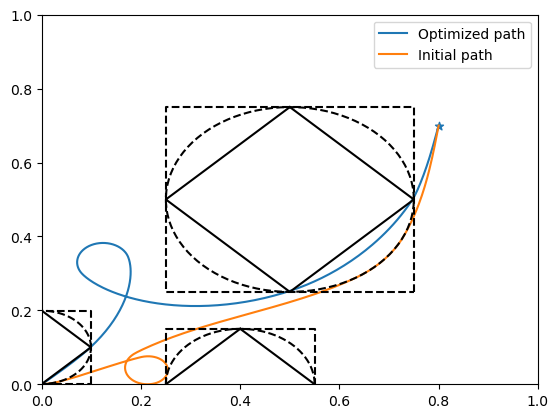

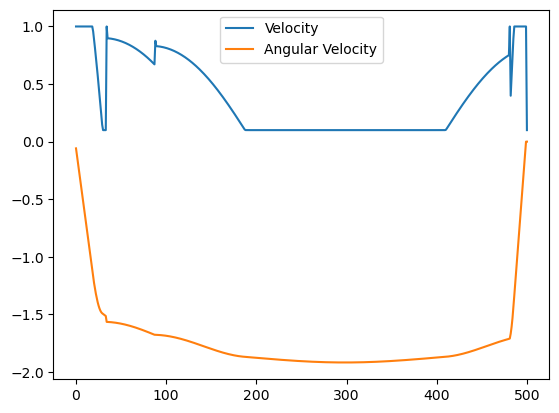

In [53]:
import matplotlib.pyplot as plt
plt.figure()

x, y, theta, v, omega = [], [], [], [], []
for k in zip(model.K0):
    x.append(pyenv.value(model.x[k]))
    y.append(pyenv.value(model.y[k]))
    theta.append(pyenv.value(model.theta[k]))
    v.append(pyenv.value(model.v[k]))
    omega.append(pyenv.value(model.omega[k]))
plt.plot(x, y, label="Optimized path")
# plt.scatter(x, y)
plt.scatter(x[0], y[0], marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])

plt.plot(initial_x, initial_y, label="Initial path")

if obstacle_shape == "circle":
    style = 'k'
else:
    style = 'k--'
# circle
t = np.linspace(0, 2*np.pi, 100)
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot(r*np.cos(t) + cx, r*np.sin(t) + cy, style)

if obstacle_shape == "diamond":
    style = 'k'
else:
    style = 'k--'
# diamond
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot([cx, cx + r, cx, cx - r, cx], [cy + r, cy, cy - r, cy, cy + r], style)

if obstacle_shape == "square":
    style = 'k'
else:
    style = 'k--'
# square
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot([cx + r, cx + r, cx - r, cx - r, cx + r], [cy -r, cy + r, cy + r, cy - r, cy - r], style)

# for poly in polygons:
#     plt.plot(poly.vertices[:,0], poly.vertices[:,1])

plt.legend()

plt.figure()
plt.plot(v, label="Velocity")
plt.plot(omega, label="Angular Velocity")
plt.legend()

Solution is sensitive to initial path provided. I am not sure how IPOPT handles initial values that are inconsitent with constraints.

Unfortunately, I don't see how to get the external function of the OED objective into pyomo. It might be better to interface directly with IPOPT.

# Direct IPOPT optimization: Example Rosenbrock function
If we use `cyipopt`, we can specify the objective function value and a gradient function, but we have to handle the constraints ourselves.

In [12]:
import jax
import jax.numpy as jnp
import cyipopt

# Define the objective function
def rosenbrock(x, user_data=None):
    x1 = x[0]
    x2 = x[1]
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

class Objective:
    def objective(self, x):
        return rosenbrock(x, user_data=None)
    def gradient(self, x):
        """Objective function gradient"""
        return jax.grad(self.objective)(x)
    def constraints(self, x):
        """Values to constrain between cl and cu"""
        return (
            (x[0] - 1)**2 + (x[1] - 1)**2,
            x[0]
        )
    def jacobian(self, x):
        """Jacobian of constraints"""
        return jax.jacfwd(self.constraints)(x)
        
problem_obj = Objective()

print(f"objective: {problem_obj.objective([1.2,1.])}\ngradient: {problem_obj.gradient([1.2,1.])}")

# Create the problem instance
problem = cyipopt.Problem(
    n=2,  # Number of decision variables
    m=2,  # Number of constraints
    problem_obj=problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = [-2.0, -2.0],  # Lower bounds for x
    ub = [2.0, 2.0],  # Upper bounds for x
    cl = [0.01, 0.0], # Lower bound for constraints
    cu = [0.01, 1.5], # Lower bound for constraints
)

# Set the initial guess for the decision variables
x0 = [2.0, 1.0]

# Solve the problem
solution, info = problem.solve(x0)

# Print the solution
print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")

objective: 19.399999999999995
gradient: [Array(211.60004, dtype=float32, weak_type=True), Array(-88.000015, dtype=float32, weak_type=True)]
This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        1
        inequality constraints with only upper bounds:        0

iter    objective 

In [18]:
x0 = [
problem_obj.objective(x0)
problem_obj.gradient(x0)
problem_obj.constraints(x0)
problem_obj.jacobian(x0)

([Array(2., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)],
 [Array(1., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)])